# 2D pattern recognition

##### Imports

In [41]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import timedelta

### Automata for pattern recognition

##### State structure

In [42]:
class AutomataState:
    def __init__(self, number, letter):
        self.transitions = {}
        self.letter = letter
        self.number = number
        self.fail = None

##### Automata builder

In [43]:
def two_d_pattern_automata(pattern_arr):
    state_number = 0
    start = AutomataState(state_number, None)
    state_number += 1
    
    #### Creating all states ####
    for pattern in pattern_arr.T:
        state = start
        for letter in pattern:
            if letter not in state.transitions:
                state.transitions[letter] = AutomataState(state_number, letter)
                state_number += 1
            state = state.transitions[letter]
    
    #### Computing fail nodes ####
    queue = list(start.transitions.values())
    for state in queue:
        state.fail = start
    while queue:
        state = queue.pop(0)
        for next_state in state.transitions.values():
            queue.append(next_state)
            
            fail_state = state.fail
            while fail_state is not None and next_state.letter not in fail_state.transitions:
                fail_state = fail_state.fail
            if fail_state is None:
                next_state.fail = start
            else:
                next_state.fail = fail_state.transitions[next_state.letter]
    
    return start

##### Determining state in every cell for each column

In [44]:
def columns_automata_pass(start_state, data_to_match):
    column_states = np.zeros(data_to_match.shape, dtype=np.int32)
    for col in range(data_to_match.shape[1]):
        state = start_state
        for row in range(data_to_match.shape[0]):
            while state is not None and data_to_match[row, col] not in state.transitions:
                state = state.fail
            if state is None:
                state = start_state
            else:
                state = state.transitions[data_to_match[row, col]]
            column_states[row, col] = state.number
    return column_states

### Matching algorithms

##### KMP matching
Used by 2D matching to match pattern of accepting states in every row in text

In [45]:
def kmp_matching(text, pattern, pi = None):
    if pi is None:
        pi = prefix_function(pattern)
    patt_len = len(pattern)
    q = 0
    correct_s = []
    for i in range(0, len(text)):
        while(q > 0 and pattern[q] != text[i]):
            q = pi[q-1]
        if(pattern[q] == text[i]):
            q = q + 1
        if(q == len(pattern)):
            correct_s.append(i - patt_len + 1)
            q = pi[q-1]
    return correct_s
            
def prefix_function(pattern):
    pi = [0]
    k = 0
    for q in range(1, len(pattern)):
        while k > 0 and pattern[k] != pattern[q]:
            k = pi[k-1]
        if pattern[k] == pattern[q]:
            k = k + 1
        pi.append(k)
    return pi

##### 2D matching
func(match_2d_pattern):

Parameters:
- $data$: np.ndarray; dataset in which pattern will be searched
- $pattern$: np.ndarray

Returns:
- _: list[tuple]; list of (y, x) indicating top-left corner coordinates of all matched patterns 

In [46]:
def match_2d_pattern(data, pattern, show_stats=False):
    if show_stats:
        print("----------------------------------------")
        print("Statistics of running matching algorithm")
        print("----------------------------------------")
        print("\t| Automata building time:", end=" ")
    start_time = time.time()
    automata = two_d_pattern_automata(pattern)
    states = columns_automata_pass(automata, data)
    states_pattern = columns_automata_pass(automata, pattern)[-1]
    end_time = time.time()
    automata_time = (end_time - start_time)*1000
    if show_stats:
        print(f"{automata_time:.3f}ms")
    pattern_height = pattern.shape[0]
    occurences = []
    
    if show_stats:
        print("----------------------------------------")
        print("\t| Matching time:", end=" ")
    start_time = time.time()
    for i, row in enumerate(states):
        for j in kmp_matching(row, states_pattern):
            occurences.append((i-pattern_height+1, j))
    end_time = time.time()
    matching_time = (end_time - start_time)*1000
    if show_stats:
        print(f"{matching_time:.3f}ms")
        print("----------------------------------------")
    return occurences, automata_time, matching_time

### Text preparation
In order to be compatible with $match\_2d\_pattern$ function, text and pattern must be put in NumPy arrays.

$prepare\_text\_to\_match$ creates NumPy array from text and overwrite empty spaces with '\n' sign which does not occur in any other place. Every line has its own row in array, so '\n' is eliminated from text and pattern.

In [47]:
def str_lines_to_ndarray(lines):
    return np.array(list(map(list, lines)))

def prepare_text_to_match(text):
    lines = text.split("\n")
    desirable_len = max(map(len, lines))
    filler = '\n'
    for row in range(len(lines)):
        lines[row] = lines[row] + (desirable_len - len(lines[row])) * filler
    return str_lines_to_ndarray(lines)

### Simple testing

In [48]:
test_text = """abbbdsa
cdab
cdcddd"""

test_pattern = """ab
cd"""

print(test_text)
print("---")
print(test_pattern)

abbbdsa
cdab
cdcddd
---
ab
cd


In [49]:
prepared_text = prepare_text_to_match(test_text)
prepared_pattern = prepare_text_to_match(test_pattern)

print(prepared_text)
print("---")
print(prepared_pattern)

[['a' 'b' 'b' 'b' 'd' 's' 'a']
 ['c' 'd' 'a' 'b' '\n' '\n' '\n']
 ['c' 'd' 'c' 'd' 'd' 'd' '\n']]
---
[['a' 'b']
 ['c' 'd']]


In [50]:
print(match_2d_pattern(prepared_text, prepared_pattern, True)[0])

----------------------------------------
Statistics of running matching algorithm
----------------------------------------
	| Automata building time: 0.111ms
----------------------------------------
	| Matching time: 0.044ms
----------------------------------------
[(0, 0), (1, 2)]


### Finding vertically double letter pattern
First example of algorithm usage is matching pattern of same letter in two consecutive lines

$$text[row,column] = text[row+1,column]$$

In [51]:
haystack_text = open("haystack.txt", 'r').read()
haystack_text_np = prepare_text_to_match(haystack_text)
letters = set(haystack_text)
letters.remove('\n')

In [52]:
for letter in sorted(letters):
    print(f"{letter}: {len(match_2d_pattern(haystack_text_np, np.array([[letter],[letter]]))[0])}")

 : 158
": 0
(: 0
): 0
,: 0
-: 0
.: 0
0: 0
1: 0
3: 0
5: 0
6: 0
7: 0
:: 0
;: 0
A: 0
B: 0
C: 0
D: 0
E: 0
F: 0
G: 0
I: 0
L: 0
M: 0
N: 0
O: 0
P: 0
Q: 0
R: 0
S: 0
T: 0
U: 0
V: 0
W: 0
X: 0
a: 28
b: 0
c: 6
d: 1
e: 48
f: 2
g: 0
h: 4
i: 13
j: 0
k: 0
l: 5
m: 5
n: 15
o: 21
p: 2
q: 0
r: 21
s: 19
t: 41
u: 0
v: 0
w: 2
x: 1
y: 1
z: 0


##### Vertically double "th" pattern

In [53]:
print("Occurences:", end=" ")
print(match_2d_pattern(haystack_text_np, prepare_text_to_match("th\nth"), True)[0])

Occurences: ----------------------------------------
Statistics of running matching algorithm
----------------------------------------
	| Automata building time: 4.225ms
----------------------------------------
	| Matching time: 3.034ms
----------------------------------------
[]


##### Vertically double "t h" pattern 

In [54]:
print("Occurences:", end=" ")
print(match_2d_pattern(haystack_text_np, prepare_text_to_match("t h\nt h"), True)[0])

Occurences: ----------------------------------------
Statistics of running matching algorithm
----------------------------------------
	| Automata building time: 8.517ms
----------------------------------------
	| Matching time: 3.008ms
----------------------------------------
[(37, 0)]


## Matching 2D patterns in image
Image provided is printed version of $haystack\_text$. 

$cv2.threshold$ is used to turn picture into black and white since around letters there are gray pixels which may vary depending on letter's placing. We do it because algorithm looks for exactly same pattern in image and even difference of 1 in value makes pattern invalid. 

In [55]:
# Load image
haystack_img = cv2.imread("haystack.png", cv2.IMREAD_GRAYSCALE)

# Binarize image (pixels below 127 become 0, other become 255)
haystack_img = cv2.threshold(haystack_img, 127, 255, cv2.THRESH_BINARY)[-1]

##### Comparing image matching to text matching

In [56]:
def check_img_match(full_img, pattern_img, full_text, pattern_text):
    img_match = len(match_2d_pattern(full_img, pattern_img)[0])
    pattern_match = len(kmp_matching(full_text, pattern_text))
    print(f"Patterns matched in image: {img_match}")
    print(f"Patterns matched in text: {pattern_match}")

### Pattern "p a t t e r n"

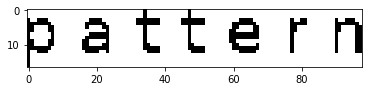

In [57]:
test_pattern_img = haystack_img[474:491,185:283]

plt.imshow(255 - test_pattern_img, cmap='Greys')
plt.show()

In [58]:
check_img_match(haystack_img, test_pattern_img, haystack_text, "p a t t e r n")

Patterns matched in image: 5
Patterns matched in text: 5


### Finding letters in image
For letters $e, a, w, q$

In [59]:
letters_postions = {
    'e': ((59, 69), (90, 99)),
    'a': ((103, 113), (56, 64)),
    'w': ((59, 69), (49, 62)),
    'q': ((147, 161), (191, 200))
}

---
Checking letter e


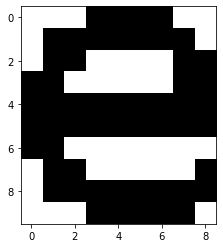

Patterns matched in image: 583
Patterns matched in text: 583
---
Checking letter a


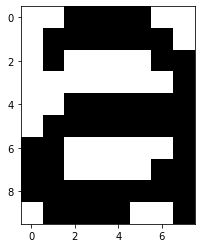

Patterns matched in image: 397
Patterns matched in text: 397
---
Checking letter w


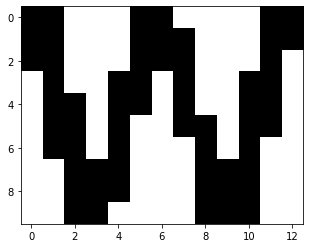

Patterns matched in image: 38
Patterns matched in text: 38
---
Checking letter q


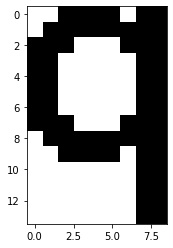

Patterns matched in image: 11
Patterns matched in text: 11


In [60]:
for letter, ((y0, y1), (x0, x1)) in letters_postions.items():
    print("---")
    print(f"Checking letter {letter}")
    letter_img = haystack_img[y0:y1, x0:x1]
    plt.imshow(255 - letter_img, cmap='Greys')
    plt.show()
    check_img_match(haystack_img, letter_img, haystack_text, letter)

### Matching times and automata building times
Now we will plot times of building automata (blue plot) and pattern matching (orange plot). Also total time will be plotted (green plot).

First plot is in linear scale, it shows that solution has linear complexity.

Second is in logaritmic scale (on both x and y axis)

In [61]:
def random_pattern(width, height):
    lines = [[chr(np.random.randint(ord('a'), ord('z')+1)) for _ in range(width)] for _ in range(height)]
    return str_lines_to_ndarray(lines)

xs = []
a_time_list = []
m_time_list = []
for i in range(1, 10):
    xs.append(2**(2*i))
    _, a_time, m_time = match_2d_pattern(haystack_text_np, random_pattern(2**i, 2**i))
    
    a_time_list.append(a_time)
    m_time_list.append(m_time)

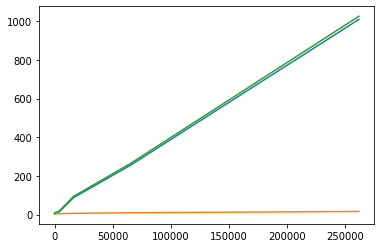

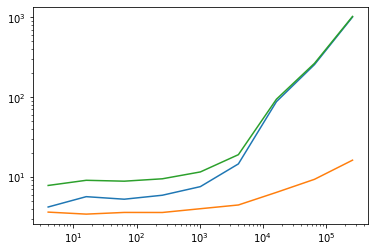

In [62]:
import itertools

plt.plot(xs, a_time_list)
plt.plot(xs, m_time_list)
plt.plot(xs, list(map(sum, itertools.zip_longest(a_time_list, m_time_list))))
plt.show()


plt.xscale("log")
plt.yscale("log")
plt.plot(xs, a_time_list)
plt.plot(xs, m_time_list)
plt.plot(xs, list(map(sum, itertools.zip_longest(a_time_list, m_time_list))))
plt.show()

We can see that for bigger patterns, automata building time is the only one which has significant influence on execution time

### Divide files and match
$haystack\_text$ is about to be divided in 2, 4 and 8 parts. We will check if pattern matching time will stay constant (approximatelly).

In [63]:
def match_by_parts(data, pattern, parts):
    rows = data.shape[0]
    rows_per_iter = rows // parts
    match_time = 0
    for i in range(parts-1):
        _, _, m_time = match_2d_pattern(data[i*rows_per_iter : (i+1)*rows_per_iter + 1], pattern)
        match_time += m_time
    _, _, m_time = match_2d_pattern(data[(parts-1)*rows_per_iter:], pattern)
    match_time += m_time
    return match_time

In [64]:
pattern_a = np.empty((100,100), dtype=np.unicode)
pattern_a[:,:] = 'a'

In [65]:
for i in [1,2,4,8]:
    print(f"{i} parts time:", end=" ")
    print(f"{match_by_parts(haystack_text_np, pattern_a, i):.3f}ms")

1 parts time: 7.928ms
2 parts time: 8.031ms
4 parts time: 7.918ms
8 parts time: 8.300ms


Experiment shows linear time complexity for matching with previously built automata